In [ ]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from vgg_cifar import vgg

import numpy as np
import random
#import wandb
#################### Random Seed 고정 ####################
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
##########################################################

model_names = sorted(name for name in vgg.__dict__
    if name.islower() and not name.startswith("__")
                     and name.startswith("vgg")
                     and callable(vgg.__dict__[name]))


parser = argparse.ArgumentParser(description='PyTorch VGG Trainer')
parser.add_argument('-a', '--arch', metavar='ARCH', default='vgg19_bn',
                    choices=model_names,
                    help='model architecture: ' + ' | '.join(model_names) +
                    ' (default: vgg19)')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=300, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=128, type=int,
                    metavar='N', help='mini-batch size (default: 128)')
parser.add_argument('--lr', '--learning-rate', default=0.05, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=5e-4, type=float,
                    metavar='W', help='weight decay (default: 5e-4)')
parser.add_argument('--print-freq', '-p', default=100, type=int,
                    metavar='N', help='print frequency (default: 20)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')
parser.add_argument('--pretrained', dest='pretrained', action='store_true',
                    help='use pre-trained model')
parser.add_argument('--half', dest='half', action='store_true',
                    help='use half-precision(16-bit) ')
parser.add_argument('--cpu', dest='cpu', action='store_true',
                    help='use cpu')
parser.add_argument('--save-dir', dest='save_dir',
                    help='The directory used to save the trained models',
                    default='save_temp', type=str)
parser.add_argument('--dataset', help='choose one of dataset : cifar10 or cifar100', default='cifar10', type=str)
parser.add_argument('--block', help='block_type', default='VGG19', type=str)

args = parser.parse_args(args=[])
print(args)
if args.dataset == "cifar10" :
    num_classes = 10
elif args.dataset == "cifar100" :
    num_classes = 100
print("dataset : ", args.dataset)
print("num classes : ", num_classes)

# Check the save_dir exists or not
#save_path = os.path.join(args.save_dir, args.dataset, args.block)
#if not os.path.exists(save_path):
#    os.makedirs(save_path)


# cudnn.benchmark = False
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
if args.dataset == "cifar10":
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=args.batch_size, shuffle=False,
    num_workers=args.workers, pin_memory=True)
elif args.dataset == "cifar100" :
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR100(root='./data', train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR100(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=args.batch_size, shuffle=False,
    num_workers=args.workers, pin_memory=True)


In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        if args.cpu == False:
            input = input.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)
        if args.half:
            input = input.half()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        if args.cpu == False:
            input = input.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

        if args.half:
            input = input.half()

        # compute output
        with torch.no_grad():
            output = model(input)
            loss = criterion(output, target)

        output = output.float()
        loss = loss.float()

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        

        if i % args.print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses,
                      top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))

    return top1.avg


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 2 every 30 epochs"""
    lr = args.lr * (0.5 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
# define loss function (criterion) and pptimizer      
def run_model(model):
    if args.cpu:
        model.cpu()
    else:
        model.cuda()
    criterion = nn.CrossEntropyLoss()
    if args.cpu:
        criterion = criterion.cpu()
    else:
        criterion = criterion.cuda()

    if args.half:
        model.half()
        criterion.half()

    best_prec1 = 0
    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)
    if args.evaluate:
        validate(val_loader, model, criterion)

    test_accuracy = []
    for epoch in range(args.start_epoch, args.epochs):
        adjust_learning_rate(optimizer, epoch)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch)

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        #save_checkpoint({
        #    'epoch': epoch + 1,
        #    'state_dict': model.state_dict(),
        #    'best_prec1': best_prec1,
        #}, is_best, filename=os.path.join(save_path, 'checkpoint_{}.tar'.format(epoch)))
        test_accuracy.append(prec1)
    return test_accuracy

In [ ]:
args.block = "VGG19"
model = vgg.__dict__[args.arch](num_classes, args.block)
model.features = torch.nn.DataParallel(model.features)

vgg19_accuracy = run_model(model)

In [ ]:
args.block = "SE_SA_1"
model = vgg.__dict__[args.arch](num_classes, args.block)
model.features = torch.nn.DataParallel(model.features)
se_sa_accuracy = run_model(model)

In [ ]:
args.block = "SEC_SA_1"
model = vgg.__dict__[args.arch](num_classes, args.block)
model.features = torch.nn.DataParallel(model.features)
sec_sa_accuracy = run_model(model)

In [ ]:
args.block = "CBAM_1"
model = vgg.__dict__[args.arch](num_classes, args.block)
model.features = torch.nn.DataParallel(model.features)
cbam_accuracy = run_model(model)

In [ ]:
args.block = "NEW_1"
model = vgg.__dict__[args.arch](num_classes, args.block)
model.features = torch.nn.DataParallel(model.features)
ours_accuracy = run_model(model)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(vgg19_accuracy, color = 'r')
plt.plot(se_sa_accuracy, color = 'y')
plt.plot(sec_sa_accuracy, color = 'b')
plt.plot(cbam_accuracy, color = 'm')
plt.plot(ours_accuracy, color = 'g')
#plt.xlim([0, 5])      # X축의 범위: [xmin, xmax]
#plt.ylim([0, 20])     # Y축의 범위: [ymin, ymax]
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from resnet_cifar.models import *
from resnet_cifar.resnet import *
from resnet_cifar.utils import progress_bar

import numpy as np
import random

#import wandb

#################### Random Seed 고정 ####################
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
##########################################################

device = 'cuda' if torch.cuda.is_available() else 'cpu'
parser = argparse.ArgumentParser(description='PyTorch ResNet Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true',
                        help='resume from checkpoint')
parser.add_argument('--epochs', default=200, type=int, metavar='N',
                        help='number of total epochs to run')
parser.add_argument('--dataset', help='dataset', default='cifar100', type=str)
parser.add_argument('--block', help='block type', default='RESNET', type=str)
parser.add_argument('--save_dir', default='save_temp', type=str)
parser.add_argument('--print-freq', '-p', default=100, type=int,
                    metavar='N', help='print frequency (default: 20)')

args = parser.parse_args(args=[])


In [2]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# classes = ('plane', 'car', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck')

if args.dataset == 'cifar10':
    trainset = torchvision.datasets.CIFAR10(
            root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
            testset, batch_size=100, shuffle=False, num_workers=2)
else:
    trainset = torchvision.datasets.CIFAR100(
            root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR100(
            root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
            testset, batch_size=100, shuffle=False, num_workers=2)

# Model
#print('==> Building model..')


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Training
def train(epoch, trainloader, net, criterion, optimizer):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    last_idx = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        last_idx = batch_idx

        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        if batch_idx % args.print_freq == 0:
            print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


    #wandb.log({
    #    'train_acc': 100.*correct/total,
    #    'train_loss': train_loss/(last_idx+1)
    #})


def test(epoch, testloader, net, criterion, best_acc):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            if batch_idx % args.print_freq == 0:
                print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    #wandb.log({
    #    'test_acc': 100.*correct/total,
    #    'test_loss': test_loss/(batch_idx+1)
    #})
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        #print('Saving..')
        #state = {
        #    'net': net.state_dict(),
        #    'acc': acc,
        #    'epoch': epoch,
        #}
        #save_path = os.path.join(args.save_dir, args.block)
        #if not os.path.exists(save_path):
        #    os.makedirs(save_path)
        #torch.save(state, os.path.join(save_path, 'checkpoint_{}.pth'.format(epoch)))
        best_acc = acc

    return acc

In [4]:
def run_model(net):
    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch

    print("model : ", net)
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        # cudnn.benchmark = True

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr,
                          momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    test_accuracy = []
    for idx in range(start_epoch, start_epoch+args.epochs):
        train(idx, trainloader, net, criterion, optimizer)
        acc = test(idx, testloader, net, criterion, best_acc)
        scheduler.step()
        test_accuracy.append(acc)
    return test_accuracy

In [5]:
args.block = "RESNET"
net = ResNet18(block=args.block, num_classes=100 if args.dataset == 'cifar100' else 10)
resnet_accuracy = run_model(net)

model :  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1


Epoch: 16
0 391 Loss: 1.167 | Acc: 67.969% (87/128)
100 391 Loss: 1.224 | Acc: 64.109% (8288/12928)
200 391 Loss: 1.248 | Acc: 63.565% (16354/25728)
300 391 Loss: 1.259 | Acc: 63.325% (24398/38528)
0 100 Loss: 1.584 | Acc: 58.000% (58/100)

Epoch: 17
0 391 Loss: 0.982 | Acc: 66.406% (85/128)
100 391 Loss: 1.149 | Acc: 66.654% (8617/12928)
200 391 Loss: 1.194 | Acc: 65.221% (16780/25728)
300 391 Loss: 1.226 | Acc: 64.397% (24811/38528)
0 100 Loss: 1.514 | Acc: 56.000% (56/100)

Epoch: 18
0 391 Loss: 1.290 | Acc: 63.281% (81/128)
100 391 Loss: 1.168 | Acc: 66.244% (8564/12928)
200 391 Loss: 1.183 | Acc: 65.730% (16911/25728)
300 391 Loss: 1.203 | Acc: 65.129% (25093/38528)
0 100 Loss: 1.582 | Acc: 60.000% (60/100)

Epoch: 19
0 391 Loss: 1.148 | Acc: 67.969% (87/128)
100 391 Loss: 1.142 | Acc: 66.801% (8636/12928)
200 391 Loss: 1.171 | Acc: 65.986% (16977/25728)
300 391 Loss: 1.193 | Acc: 65.547% (25254/38528)
0 100 Loss: 1.935 | Acc: 56.000% (56/100)

Epoch: 20
0 391 Loss: 1.328 | Acc: 


Epoch: 50
0 391 Loss: 0.801 | Acc: 74.219% (95/128)
100 391 Loss: 0.850 | Acc: 74.466% (9627/12928)
200 391 Loss: 0.879 | Acc: 73.884% (19009/25728)
300 391 Loss: 0.906 | Acc: 73.152% (28184/38528)
0 100 Loss: 1.444 | Acc: 56.000% (56/100)

Epoch: 51
0 391 Loss: 0.901 | Acc: 71.875% (92/128)
100 391 Loss: 0.808 | Acc: 76.006% (9826/12928)
200 391 Loss: 0.852 | Acc: 74.677% (19213/25728)
300 391 Loss: 0.888 | Acc: 73.720% (28403/38528)
0 100 Loss: 1.391 | Acc: 64.000% (64/100)

Epoch: 52
0 391 Loss: 0.569 | Acc: 82.031% (105/128)
100 391 Loss: 0.842 | Acc: 74.892% (9682/12928)
200 391 Loss: 0.860 | Acc: 74.141% (19075/25728)
300 391 Loss: 0.892 | Acc: 73.370% (28268/38528)
0 100 Loss: 1.311 | Acc: 64.000% (64/100)

Epoch: 53
0 391 Loss: 0.993 | Acc: 73.438% (94/128)
100 391 Loss: 0.832 | Acc: 75.054% (9703/12928)
200 391 Loss: 0.864 | Acc: 73.896% (19012/25728)
300 391 Loss: 0.887 | Acc: 73.380% (28272/38528)
0 100 Loss: 1.401 | Acc: 62.000% (62/100)

Epoch: 54
0 391 Loss: 0.699 | Acc:

0 100 Loss: 1.846 | Acc: 60.000% (60/100)

Epoch: 84
0 391 Loss: 0.590 | Acc: 81.250% (104/128)
100 391 Loss: 0.602 | Acc: 81.521% (10539/12928)
200 391 Loss: 0.616 | Acc: 81.017% (20844/25728)
300 391 Loss: 0.638 | Acc: 80.378% (30968/38528)
0 100 Loss: 1.499 | Acc: 61.000% (61/100)

Epoch: 85
0 391 Loss: 0.527 | Acc: 83.594% (107/128)
100 391 Loss: 0.584 | Acc: 82.024% (10604/12928)
200 391 Loss: 0.616 | Acc: 80.927% (20821/25728)
300 391 Loss: 0.642 | Acc: 80.214% (30905/38528)
0 100 Loss: 1.434 | Acc: 63.000% (63/100)

Epoch: 86
0 391 Loss: 0.623 | Acc: 80.469% (103/128)
100 391 Loss: 0.565 | Acc: 82.890% (10716/12928)
200 391 Loss: 0.598 | Acc: 81.635% (21003/25728)
300 391 Loss: 0.626 | Acc: 80.746% (31110/38528)
0 100 Loss: 1.244 | Acc: 70.000% (70/100)

Epoch: 87
0 391 Loss: 0.724 | Acc: 78.906% (101/128)
100 391 Loss: 0.571 | Acc: 82.751% (10698/12928)
200 391 Loss: 0.586 | Acc: 82.311% (21177/25728)
300 391 Loss: 0.619 | Acc: 81.310% (31327/38528)
0 100 Loss: 1.316 | Acc: 64.

300 391 Loss: 0.305 | Acc: 90.768% (34971/38528)
0 100 Loss: 1.285 | Acc: 68.000% (68/100)

Epoch: 118
0 391 Loss: 0.238 | Acc: 92.969% (119/128)
100 391 Loss: 0.300 | Acc: 90.579% (11710/12928)
200 391 Loss: 0.306 | Acc: 90.497% (23283/25728)
300 391 Loss: 0.323 | Acc: 89.836% (34612/38528)
0 100 Loss: 1.322 | Acc: 71.000% (71/100)

Epoch: 119
0 391 Loss: 0.397 | Acc: 84.375% (108/128)
100 391 Loss: 0.290 | Acc: 91.197% (11790/12928)
200 391 Loss: 0.294 | Acc: 91.049% (23425/25728)
300 391 Loss: 0.311 | Acc: 90.415% (34835/38528)
0 100 Loss: 1.433 | Acc: 71.000% (71/100)

Epoch: 120
0 391 Loss: 0.200 | Acc: 93.750% (120/128)
100 391 Loss: 0.260 | Acc: 92.218% (11922/12928)
200 391 Loss: 0.270 | Acc: 91.950% (23657/25728)
300 391 Loss: 0.283 | Acc: 91.380% (35207/38528)
0 100 Loss: 1.392 | Acc: 69.000% (69/100)

Epoch: 121
0 391 Loss: 0.235 | Acc: 92.188% (118/128)
100 391 Loss: 0.273 | Acc: 91.507% (11830/12928)
200 391 Loss: 0.275 | Acc: 91.531% (23549/25728)
300 391 Loss: 0.286 | Ac

100 391 Loss: 0.037 | Acc: 99.389% (12849/12928)
200 391 Loss: 0.034 | Acc: 99.483% (25595/25728)
300 391 Loss: 0.035 | Acc: 99.447% (38315/38528)
0 100 Loss: 0.948 | Acc: 76.000% (76/100)

Epoch: 152
0 391 Loss: 0.026 | Acc: 100.000% (128/128)
100 391 Loss: 0.033 | Acc: 99.428% (12854/12928)
200 391 Loss: 0.032 | Acc: 99.510% (25602/25728)
300 391 Loss: 0.030 | Acc: 99.574% (38364/38528)
0 100 Loss: 1.090 | Acc: 74.000% (74/100)

Epoch: 153
0 391 Loss: 0.019 | Acc: 100.000% (128/128)
100 391 Loss: 0.027 | Acc: 99.606% (12877/12928)
200 391 Loss: 0.024 | Acc: 99.705% (25652/25728)
300 391 Loss: 0.024 | Acc: 99.712% (38417/38528)
0 100 Loss: 1.080 | Acc: 76.000% (76/100)

Epoch: 154
0 391 Loss: 0.041 | Acc: 98.438% (126/128)
100 391 Loss: 0.023 | Acc: 99.760% (12897/12928)
200 391 Loss: 0.022 | Acc: 99.763% (25667/25728)
300 391 Loss: 0.023 | Acc: 99.746% (38430/38528)
0 100 Loss: 1.018 | Acc: 74.000% (74/100)

Epoch: 155
0 391 Loss: 0.024 | Acc: 99.219% (127/128)
100 391 Loss: 0.021 | 

0 100 Loss: 0.848 | Acc: 75.000% (75/100)

Epoch: 185
0 391 Loss: 0.007 | Acc: 100.000% (128/128)
100 391 Loss: 0.010 | Acc: 99.961% (12923/12928)
200 391 Loss: 0.009 | Acc: 99.973% (25721/25728)
300 391 Loss: 0.009 | Acc: 99.966% (38515/38528)
0 100 Loss: 0.846 | Acc: 75.000% (75/100)

Epoch: 186
0 391 Loss: 0.009 | Acc: 100.000% (128/128)
100 391 Loss: 0.009 | Acc: 99.969% (12924/12928)
200 391 Loss: 0.009 | Acc: 99.969% (25720/25728)
300 391 Loss: 0.010 | Acc: 99.958% (38512/38528)
0 100 Loss: 0.823 | Acc: 75.000% (75/100)

Epoch: 187
0 391 Loss: 0.007 | Acc: 100.000% (128/128)
100 391 Loss: 0.009 | Acc: 99.992% (12927/12928)
200 391 Loss: 0.009 | Acc: 99.988% (25725/25728)
300 391 Loss: 0.009 | Acc: 99.971% (38517/38528)
0 100 Loss: 0.849 | Acc: 75.000% (75/100)

Epoch: 188
0 391 Loss: 0.012 | Acc: 100.000% (128/128)
100 391 Loss: 0.009 | Acc: 99.961% (12923/12928)
200 391 Loss: 0.009 | Acc: 99.973% (25721/25728)
300 391 Loss: 0.009 | Acc: 99.977% (38519/38528)
0 100 Loss: 0.842 | 

In [ ]:
args.block = "SE_SA_1"
net = ResNet18(block=args.block, num_classes=100 if args.dataset == 'cifar100' else 10)
se_sa_accuracy = run_model(net)

In [ ]:
#args.block = "SEC_SA_1"
#net = ResNet18(block=args.block, num_classes=100 if args.dataset == 'cifar100' else 10)
#sec_sa_accuracy = run_model(net)

In [ ]:
args.block = "CBAM_1"
net = ResNet18(block=args.block, num_classes=100 if args.dataset == 'cifar100' else 10)
cbam_accuracy = run_model(net)

In [13]:
args.block = "NEW_1"
net = ResNet18(block=args.block, num_classes=100 if args.dataset == 'cifar100' else 10)
ours_accuracy = run_model(net)

model :  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (image_module): NewBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=8, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=8, out_features=64, bias=False)
          (3): Sigmoid()
        )
        (sg): SpatialGate(
          (compress

C:\Users\owner\anaconda3\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 391 Loss: 4.745 | Acc: 0.781% (1/128)
100 391 Loss: 4.380 | Acc: 5.012% (648/12928)
200 391 Loss: 4.162 | Acc: 6.744% (1735/25728)
300 391 Loss: 4.030 | Acc: 8.142% (3137/38528)
0 100 Loss: 3.835 | Acc: 13.000% (13/100)

Epoch: 1
0 391 Loss: 3.909 | Acc: 11.719% (15/128)
100 391 Loss: 3.503 | Acc: 15.292% (1977/12928)
200 391 Loss: 3.428 | Acc: 16.791% (4320/25728)
300 391 Loss: 3.375 | Acc: 17.782% (6851/38528)
0 100 Loss: 3.336 | Acc: 19.000% (19/100)

Epoch: 2
0 391 Loss: 3.124 | Acc: 21.875% (28/128)
100 391 Loss: 2.988 | Acc: 25.124% (3248/12928)
200 391 Loss: 2.932 | Acc: 25.995% (6688/25728)
300 391 Loss: 2.878 | Acc: 26.947% (10382/38528)
0 100 Loss: 2.931 | Acc: 28.000% (28/100)

Epoch: 3
0 391 Loss: 2.507 | Acc: 35.156% (45/128)
100 391 Loss: 2.500 | Acc: 34.568% (4469/12928)
200 391 Loss: 2.458 | Acc: 35.549% (9146/25728)
300 391 Loss: 2.409 | Acc: 36.529% (14074/38528)
0 100 Loss: 2.544 | Acc: 30.000% (30/100)

Epoch: 4
0 391 Loss: 2.193 | Acc: 40.625% (52/128)
100 391 Lo

100 391 Loss: 0.939 | Acc: 72.099% (9321/12928)
200 391 Loss: 0.972 | Acc: 71.335% (18353/25728)
300 391 Loss: 0.988 | Acc: 70.954% (27337/38528)
0 100 Loss: 1.660 | Acc: 60.000% (60/100)

Epoch: 35
0 391 Loss: 1.012 | Acc: 70.312% (90/128)
100 391 Loss: 0.917 | Acc: 73.321% (9479/12928)
200 391 Loss: 0.949 | Acc: 72.252% (18589/25728)
300 391 Loss: 0.974 | Acc: 71.434% (27522/38528)
0 100 Loss: 1.416 | Acc: 68.000% (68/100)

Epoch: 36
0 391 Loss: 1.084 | Acc: 64.062% (82/128)
100 391 Loss: 0.883 | Acc: 73.476% (9499/12928)
200 391 Loss: 0.931 | Acc: 72.458% (18642/25728)
300 391 Loss: 0.962 | Acc: 71.532% (27560/38528)
0 100 Loss: 1.831 | Acc: 58.000% (58/100)

Epoch: 37
0 391 Loss: 0.959 | Acc: 71.094% (91/128)
100 391 Loss: 0.909 | Acc: 73.438% (9494/12928)
200 391 Loss: 0.940 | Acc: 72.221% (18581/25728)
300 391 Loss: 0.963 | Acc: 71.626% (27596/38528)
0 100 Loss: 1.415 | Acc: 62.000% (62/100)

Epoch: 38
0 391 Loss: 0.844 | Acc: 74.219% (95/128)
100 391 Loss: 0.889 | Acc: 73.554% (

100 391 Loss: 0.706 | Acc: 78.380% (10133/12928)
200 391 Loss: 0.730 | Acc: 77.865% (20033/25728)
300 391 Loss: 0.750 | Acc: 77.367% (29808/38528)
0 100 Loss: 1.417 | Acc: 59.000% (59/100)

Epoch: 69
0 391 Loss: 0.774 | Acc: 79.688% (102/128)
100 391 Loss: 0.675 | Acc: 79.618% (10293/12928)
200 391 Loss: 0.723 | Acc: 78.152% (20107/25728)
300 391 Loss: 0.752 | Acc: 77.281% (29775/38528)
0 100 Loss: 1.581 | Acc: 62.000% (62/100)

Epoch: 70
0 391 Loss: 0.728 | Acc: 74.219% (95/128)
100 391 Loss: 0.681 | Acc: 79.626% (10294/12928)
200 391 Loss: 0.717 | Acc: 78.560% (20212/25728)
300 391 Loss: 0.747 | Acc: 77.621% (29906/38528)
0 100 Loss: 1.339 | Acc: 68.000% (68/100)

Epoch: 71
0 391 Loss: 0.592 | Acc: 83.594% (107/128)
100 391 Loss: 0.668 | Acc: 79.920% (10332/12928)
200 391 Loss: 0.704 | Acc: 78.634% (20231/25728)
300 391 Loss: 0.729 | Acc: 77.891% (30010/38528)
0 100 Loss: 1.575 | Acc: 65.000% (65/100)

Epoch: 72
0 391 Loss: 0.623 | Acc: 85.156% (109/128)
100 391 Loss: 0.674 | Acc: 79


Epoch: 102
0 391 Loss: 0.455 | Acc: 88.281% (113/128)
100 391 Loss: 0.415 | Acc: 87.392% (11298/12928)
200 391 Loss: 0.446 | Acc: 86.315% (22207/25728)
300 391 Loss: 0.468 | Acc: 85.556% (32963/38528)
0 100 Loss: 1.681 | Acc: 61.000% (61/100)

Epoch: 103
0 391 Loss: 0.454 | Acc: 85.156% (109/128)
100 391 Loss: 0.430 | Acc: 86.734% (11213/12928)
200 391 Loss: 0.432 | Acc: 86.641% (22291/25728)
300 391 Loss: 0.445 | Acc: 86.137% (33187/38528)
0 100 Loss: 1.457 | Acc: 62.000% (62/100)

Epoch: 104
0 391 Loss: 0.473 | Acc: 87.500% (112/128)
100 391 Loss: 0.403 | Acc: 87.732% (11342/12928)
200 391 Loss: 0.425 | Acc: 87.096% (22408/25728)
300 391 Loss: 0.441 | Acc: 86.480% (33319/38528)
0 100 Loss: 1.255 | Acc: 73.000% (73/100)

Epoch: 105
0 391 Loss: 0.544 | Acc: 83.594% (107/128)
100 391 Loss: 0.397 | Acc: 87.369% (11295/12928)
200 391 Loss: 0.425 | Acc: 86.521% (22260/25728)
300 391 Loss: 0.441 | Acc: 86.194% (33209/38528)
0 100 Loss: 1.835 | Acc: 56.000% (56/100)

Epoch: 106
0 391 Loss: 

300 391 Loss: 0.146 | Acc: 95.845% (36927/38528)
0 100 Loss: 1.191 | Acc: 72.000% (72/100)

Epoch: 136
0 391 Loss: 0.096 | Acc: 98.438% (126/128)
100 391 Loss: 0.147 | Acc: 95.869% (12394/12928)
200 391 Loss: 0.147 | Acc: 95.829% (24655/25728)
300 391 Loss: 0.152 | Acc: 95.704% (36873/38528)
0 100 Loss: 1.363 | Acc: 72.000% (72/100)

Epoch: 137
0 391 Loss: 0.088 | Acc: 98.438% (126/128)
100 391 Loss: 0.127 | Acc: 96.511% (12477/12928)
200 391 Loss: 0.129 | Acc: 96.486% (24824/25728)
300 391 Loss: 0.135 | Acc: 96.255% (37085/38528)
0 100 Loss: 1.282 | Acc: 75.000% (75/100)

Epoch: 138
0 391 Loss: 0.081 | Acc: 97.656% (125/128)
100 391 Loss: 0.115 | Acc: 96.937% (12532/12928)
200 391 Loss: 0.120 | Acc: 96.755% (24893/25728)
300 391 Loss: 0.126 | Acc: 96.571% (37207/38528)
0 100 Loss: 1.393 | Acc: 68.000% (68/100)

Epoch: 139
0 391 Loss: 0.118 | Acc: 96.875% (124/128)
100 391 Loss: 0.116 | Acc: 97.076% (12550/12928)
200 391 Loss: 0.128 | Acc: 96.545% (24839/25728)
300 391 Loss: 0.137 | Ac

100 391 Loss: 0.011 | Acc: 99.954% (12922/12928)
200 391 Loss: 0.011 | Acc: 99.953% (25716/25728)
300 391 Loss: 0.010 | Acc: 99.956% (38511/38528)
0 100 Loss: 0.915 | Acc: 76.000% (76/100)

Epoch: 170
0 391 Loss: 0.010 | Acc: 100.000% (128/128)
100 391 Loss: 0.009 | Acc: 99.969% (12924/12928)
200 391 Loss: 0.009 | Acc: 99.977% (25722/25728)
300 391 Loss: 0.010 | Acc: 99.966% (38515/38528)
0 100 Loss: 0.906 | Acc: 75.000% (75/100)

Epoch: 171
0 391 Loss: 0.011 | Acc: 100.000% (128/128)
100 391 Loss: 0.010 | Acc: 99.915% (12917/12928)
200 391 Loss: 0.010 | Acc: 99.934% (25711/25728)
300 391 Loss: 0.010 | Acc: 99.940% (38505/38528)
0 100 Loss: 0.903 | Acc: 76.000% (76/100)

Epoch: 172
0 391 Loss: 0.007 | Acc: 100.000% (128/128)
100 391 Loss: 0.010 | Acc: 99.961% (12923/12928)
200 391 Loss: 0.010 | Acc: 99.961% (25718/25728)
300 391 Loss: 0.010 | Acc: 99.951% (38509/38528)
0 100 Loss: 0.933 | Acc: 75.000% (75/100)

Epoch: 173
0 391 Loss: 0.008 | Acc: 100.000% (128/128)
100 391 Loss: 0.010 

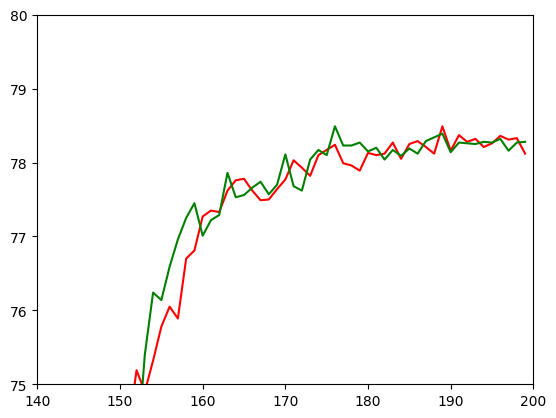

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(resnet_accuracy, color = 'r')
#plt.plot(se_sa_accuracy, color = 'y')
#plt.plot(sec_sa_accuracy, color = 'b')
#plt.plot(cbam_accuracy, color = 'm')
plt.plot(ours_accuracy, color = 'g')
plt.xlim([140, 200])      # X축의 범위: [xmin, xmax]
plt.ylim([75, 80])     # Y축의 범위: [ymin, ymax]
plt.show()